In [1]:
using Random

In [15]:
include("../rollout.jl")

In [3]:
include("../testfns.jl")

### Psuedo-code for Rollout Bayesian Optimization
1. Generate low-discrepancy sequence for Quasi-Monte Carlo
2. Gather initial samples/experimental data
3. Construct the ground truth surrogate model
4. Setup hyperparameters for stochastic gradient descent
5. While budget has not been exhausted
<ol>
    <li>
        Construct a batch of samples for stochastic gradient descent. For each sample
        <ol>
            <li>Create a copy of the ground truth surrogate at the sample location and the pairwise perturbed surrogate.</li>
            <li style="color: #f66">Initialize our trajectory struct with the fantasized surrogate and fantisized perturbed surrogate and fantasy start location.</li>
            <li>Perform rollout on the trajectory for $r$ steps $M_0$ times for Quasi-Monte Carlo integration.</li>
            <li>Update values for $\alpha$ and $\nabla\alpha$</li>
        </ol>
    </li>
    <li>Once SGD has converged, update sample location using update rule</li>
    <li>Save location and value at location for each sample in batch.</li>
    <li>Select the best sample from the batch and sample original process at new sample location.</li>
    <li>Update surrogate model with value found at new sample location.</li>
    <li>Repeat until budget is exhausted.</li>
</ol>

### Issues
- Use control variates to see how they affect the rollout acquisition functions

#### Probability of Improvement
The probability of improvement (POI) is defined as follows:

$$
POI(x) = \Phi\left( \frac{\mu(x) - f^+ - \xi}{\sigma(x)} \right)
$$

where $f^+$ denotes the best value (maximum) known, $\mu(x)$ is the predictive mean at x, $\sigma(x)$ is the predictive variance, $\xi$ is our exploration parameter, and $\Phi$ is the standard normal cumulative distribution function.
<hr>

#### Expected Improvement
The expected improvement (EI) is defined as follows:

$$
EI(x) = (\mu(x) - f^+ - \xi)\Phi\left( \frac{\mu(x) - f^+ - \xi}{\sigma(x)} \right) +
        \sigma(x)\phi\left(\frac{\mu(x) - f^+ - \xi}{\sigma(x)}\right)
$$

where $\phi$ is the standard normal probability density function.
<hr>

In [26]:
function ei(μ, σ, fbest)
    z = (fbest - μ) / σ
    Φz = Distributions.normcdf(z)
    ϕz = Distributions.normpdf(z)
    return σ*(z*Φz + ϕz)
end

function poi(μ, σ, fbest)
    z = (fbest - μ) / σ
    Φz = Distributions.normcdf(z)
    return Φz
end

poi (generic function with 1 method)

In [27]:
# Global parameters
MAX_SGD_ITERS = 500
BATCH_SIZE = 64
HORIZON = 0
MC_SAMPLES = 25
BUDGET = 1;

### 1. Generate low-discrepancy sequence for Quasi-Monte Carlo

In [28]:
# Setup toy problem
# testfn = TestFunction(
#     1, [0. 1.], [.5],
#     x -> 0. + 1e-6*randn(),
#     ∇x -> [0. + 1e-6*randn()]
# )
testfn = TestAckley(1)
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]

# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1);
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

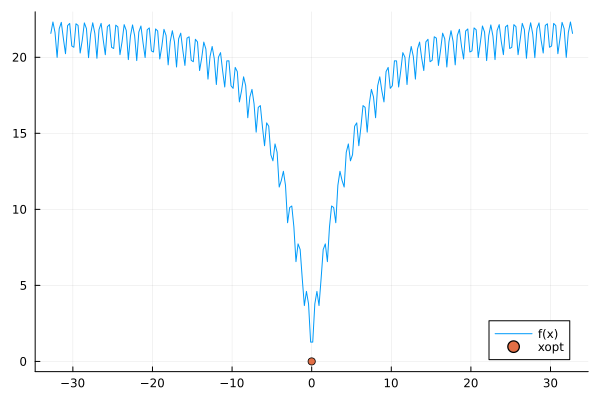

In [29]:
tplot(testfn)

### 2. Gather initial samples/experimental data

In [36]:
# Gather initial samples/experimental data
N, θ = 1, [.25]
# X = [.15, .85]
X = [21.7, 15.8, -15.8, -17.8, -21.7]
# X = collect(-16.:2:16)
X = reshape(X, 1, length(X))
# ψ = kernel_matern52(θ);
ψ = kernel_scale(kernel_matern52, [1., θ...]);

### 3. Construct the ground truth surrogate model

In [37]:
sur = fit_surrogate(ψ, X, testfn.f);
res = optimize_hypers_optim(sur, kernel_matern52)
σ, ℓ = Optim.minimizer(res)
ψ = kernel_scale(kernel_matern52, [σ, ℓ]);
sur = fit_surrogate(ψ, X, testfn.f);

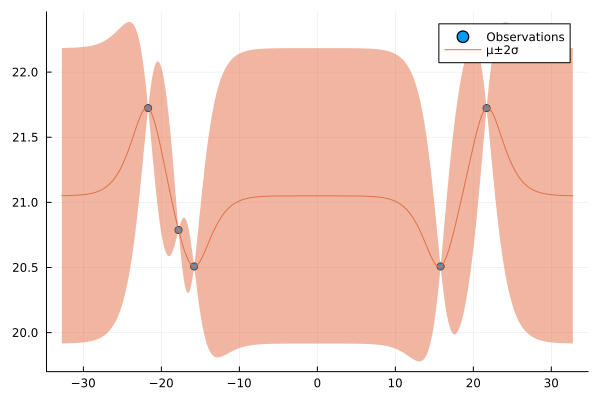

In [38]:
domain = filter(x -> !(x in X), lbs[1]:.01:ubs[1])
plot1D(sur; domain=domain)

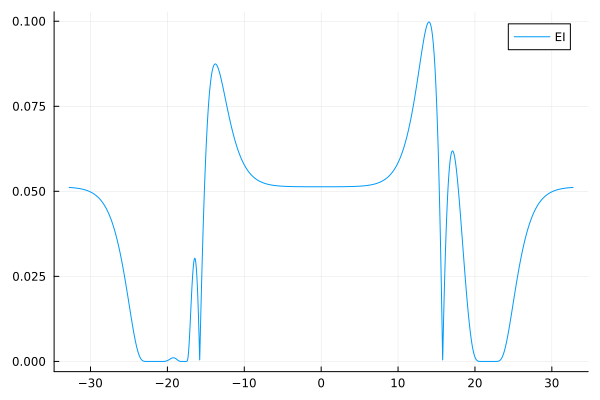

In [39]:
plot1DEI(sur, domain=domain)

### 4. Setup hyperparameters for stochastic gradient descent

In [40]:
# Define the parameters of the optimizer
λ = 0.01  # Learning rate
β1 = 0.9  # First moment decay rate
β2 = 0.999  # Second moment decay rate
ϵ = 1e-8  # Epsilon value

# Define the initial position and moment estimates
m = zeros(testfn.dim)
v = zeros(testfn.dim)

ϵsgd = 1e-12
grad_tol = 1e-5

1.0e-5

### 5. While budget has not been exhausted
Each location in our minibatch is going to be our $x^0$ that serves as our deterministic start location. Then, we perform rollout from that point forward, computing several sample trajectories to then be averaged.

We need a few mechanisms:
* We shouldn't sample at locations that are near known locations in sur.X
* We should perform the evaluations in parallel to save time

In [ ]:
minis = [minimum(sur.y) + sur.ymean]
fbest = testfn.f(testfn.xopt...)

In [ ]:
∇αxs = []
batch = []

final_locations = []

println("Beginning Bayesian Optimization Loop")
for b in 1:BUDGET
    # Generate a batch of evaluation locations and filter out locations that are close
    # to know sample locations
    batch = generate_batch(BATCH_SIZE; lbs=lbs, ubs=ubs)
    # batch = convert(Matrix{Float64}, filter(x -> !(x in sur.X), batch)')
    
    batch_evals = []
    final_locations = []
    
    # This should be a parallel for loop
    println("---------- BO Iteration #$b ----------")
    bndx = 1
    for x0 in eachcol(batch)
        try
            x0 = convert(Vector{Float64}, x0)

            αxs, ∇αxs = [], []
            ∇αxs = [0., 1., 2.]

            print("\n(Batch #$bndx - $x0) Gradient Ascent Iteration Count: ")
            # Run SGD until convergence
            fprev, fnow = 0., 1.
            for epoch in 1:MAX_SGD_ITERS
                if mod(epoch, 25) == 0 print("|") end
                μx, ∇μx = simulate_trajectory(
                    sur; mc_iters=MC_SAMPLES, rnstream=lds_rns, lbs=lbs, ubs=ubs, x0=x0, h=HORIZON
                )

                # Update gradient vector
                push!(αxs, μx)
                push!(∇αxs, first(∇μx))

                fprev = fnow
                fnow = μx

                # Update x0 based on gradient computation
                x0, m, v = update_x_adam(x0; ∇g=-∇μx, λ=λ, β1=β1, β2=β2, ϵ=ϵ, m=m, v=v, lbs=lbs, ubs=ubs)
                # x0 = update_x(x0; λ=λ, ∇g=∇μx, lbs=lbs, ubs=ubs)

                if abs(fnow - fprev) < ϵsgd || norm(∇μx) < grad_tol
                    println("\nConverged after $epoch epochs")
                    # println("abs(fnow - fprev): $(abs(fnow - fprev)) - fnow: $fnow - fprev: $fprev")
                    break
                end

            end

            push!(batch_evals, αxs[end])
            push!(final_locations, x0)
            bndx += 1
        catch e
            bndx += 1
            println(e)
        end
    end
    # Iterate over batch for best response and sample original process afterwards
    if length(batch_evals) > 0
        println()
        [println("α($(pair[1])) = $(pair[2])") for pair in zip(final_locations, batch_evals)]
        ndx = argmax(batch_evals)
        xnew = final_locations[ndx]

        # Sample original process at x0
        println("\nFinal xnew: $xnew")
        println("--------------------------------------\n")
        res = optimize_hypers_optim(sur, kernel_matern52)
        σ, ℓ = Optim.minimizer(res)
        println("Learned Kernel Hyperparameters: σ=$σ -- ℓ=$ℓ")
        ψ = kernel_scale(kernel_matern52, [σ, ℓ]);
        recover_y = sur.y .+ sur.ymean
        sur = fit_surrogate(
            ψ,
            hcat(sur.X, xnew),
            vcat(recover_y, testfn.f(xnew))
        )
        
        push!(minis, minimum(sur.y) + sur.ymean)
    end
end

In [ ]:
domain = filter(x -> !(x in sur.X), lbs[1]:.01:ubs[1])
plot1D(sur; domain=domain)

In [ ]:
init_mini = minis[1]
gap = (init_mini .- minis) / (init_mini - fbest)

In [ ]:
plot(gap)

### Parallel Bayesian Optimization

In [41]:
results = []
BATCH_SIZE = 4

println("Beginning Bayesian Optimization Loop")
for b in 1:BUDGET
    # Generate a batch of evaluation locations and filter out locations that are close
    # to know sample locations
    batch = generate_batch(BATCH_SIZE; lbs=lbs, ubs=ubs)

    # This should be a parallel for loop
    println("---------- BO Iteration #$b ----------")
    batch_results = @distributed (append!) for j = 1:size(batch, 2)
        # Define the parameters of the optimizer
        λ = 0.01  # Learning rate
        β1 = 0.9  # First moment decay rate
        β2 = 0.999  # Second moment decay rate
        ϵ = 1e-8  # Epsilon value

        # Define the initial position and moment estimates
        m = zeros(testfn.dim)
        v = zeros(testfn.dim)

        ϵsgd = 1e-12
        grad_tol = 1e-5

        x0 = batch[:, j]

        αxs, ∇αxs = [], []
        ∇αxs = [0., 1., 2.]

        # Run SGD until convergence
        fprev, fnow = 0., 1.
        try
            iters = 1
            for epoch in 1:MAX_SGD_ITERS
                μx, ∇μx = simulate_trajectory(
                    sur; mc_iters=MC_SAMPLES, rnstream=lds_rns, lbs=lbs, ubs=ubs, x0=x0, h=HORIZON
                )

                # Update gradient vector
                push!(αxs, μx)
                push!(∇αxs, first(∇μx))
                
                fprev = fnow
                fnow = μx
                
                # x0, m, v = update_x_adam(x0; ∇g=-∇μx, λ=λ, β1=β1, β2=β2, ϵ=ϵ, m=m, v=v, lbs=lbs, ubs=ubs)
                x0 = update_x(x0; λ=λ, ∇g=∇μx, lbs=lbs, ubs=ubs)

                println("norm(∇μx) = $(norm(∇μx)) -- ∇μx = $(∇μx) -- μx = $(μx)")
                iters = epoch
                if abs(fnow - fprev) < ϵsgd || norm(∇μx) < grad_tol
                    break
                end
            end
                
            [(x0, αxs[end], iters)]
        catch e
            println(e)
            [(x0, -Inf, 0)]
        end
    end
    println("Parallel Eval #$b Done")

    results = batch_results
end


Beginning Bayesian Optimization Loop
---------- BO Iteration #1 ----------
      From worker 3:	y = [0.7774897000637038, -0.43821178238751224, -0.43821178238751224, -0.15847345506097477, 0.7774897000637038, -0.5200823802914084, -0.07287004888389959] -- typeof(y) = Vector{Float64}
      From worker 6:	y = [0.6916595040143614, -0.5240419784368546, -0.5240419784368546, -0.24430365111031715, 0.6916595040143614, -0.09093140004469635, -0.18827718550884498] -- typeof(y) = Vector{Float64}
      From worker 5:	y = [0.7486362260206488, -0.4670652564305672, -0.4670652564305672, -0.1873269291040297, 0.7486362260206488, -0.3758150100761335, 0.007790620926151348] -- typeof(y) = Vector{Float64}
      From worker 8:	y = [0.6905494308882064, -0.5251520515630096, -0.5251520515630096, -0.24541372423647206, 0.6905494308882064, -0.08538103441392177, 0.19138968743170892] -- typeof(y) = Vector{Float64}
      From worker 9:	y = [0.6299988598977624, -0.5857026225534536, -0.5857026225534536, -0.3059642952269161

Excessive output truncated after 524371 bytes.

      From worker 6:	y = [0.6922527917210785, -0.5234486907301376, -0.5234486907301376, -0.24371036340360006, 0.6922527917210785, -0.09389783857828189, -0.18866648798798735] -- typeof(y) = Vector{Float64}
      From worker 6:	y = [0.6528320754558292, -0.5628694069953868, -0.5628694069953868, -0.2831310796688493, 0.6528320754558292, 0.10320574274796455, -0.16367320554433462] -- typeof(y) = Vector{Float64}
      From worker 6:	y = [0.5918931308153204, -0.6238083516358957, -0.6238083516358957, -0.3440700243093582, 0.5918931308153204, 0.40790046595050866, -0.12503706403599324] -- typeof(y) = Vector{Float64}


LoadError: TaskFailedException

[91m    nested task error: [39mOn worker 10:
    UndefVarError: TestFunction not defined
    Stacktrace:
      [1] [0m[1mdeserialize_datatype[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Serialization/src/[39m[90m[4mSerialization.jl:1364[24m[39m
      [2] [0m[1mhandle_deserialize[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Serialization/src/[39m[90m[4mSerialization.jl:866[24m[39m
      [3] [0m[1mdeserialize[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Serialization/src/[39m[90m[4mSerialization.jl:813[24m[39m
      [4] [0m[1mhandle_deserialize[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Serialization/src/[39m[90m[4mSerialization.jl:873[24m[39m
      [5] [0m[1mdeserialize[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Serialization/src/[39m[90m[4mSerialization.jl:813[24m[39m[90m [inlined][39m
      [6] [0m[1mdeserialize_global_from_main[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Distributed/src/[39m[90m[4mclusterserialize.jl:160[24m[39m
      [7] [0m[1m#5[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Distributed/src/[39m[90m[4mclusterserialize.jl:72[24m[39m[90m [inlined][39m
      [8] [0m[1mforeach[22m
    [90m    @ [39m[90m./[39m[90m[4mabstractarray.jl:2774[24m[39m
      [9] [0m[1mdeserialize[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Distributed/src/[39m[90m[4mclusterserialize.jl:72[24m[39m
     [10] [0m[1mhandle_deserialize[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Serialization/src/[39m[90m[4mSerialization.jl:959[24m[39m
     [11] [0m[1mdeserialize[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Serialization/src/[39m[90m[4mSerialization.jl:813[24m[39m
     [12] [0m[1mdeserialize_datatype[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Serialization/src/[39m[90m[4mSerialization.jl:0[24m[39m
     [13] [0m[1mhandle_deserialize[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Serialization/src/[39m[90m[4mSerialization.jl:868[24m[39m
     [14] [0m[1mdeserialize[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Serialization/src/[39m[90m[4mSerialization.jl:813[24m[39m
     [15] [0m[1mhandle_deserialize[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Serialization/src/[39m[90m[4mSerialization.jl:873[24m[39m
     [16] [0m[1mdeserialize[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Serialization/src/[39m[90m[4mSerialization.jl:813[24m[39m[90m [inlined][39m
     [17] [0m[1mdeserialize_msg[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Distributed/src/[39m[90m[4mmessages.jl:87[24m[39m
     [18] [0m[1m#invokelatest#2[22m
    [90m    @ [39m[90m./[39m[90m[4messentials.jl:729[24m[39m[90m [inlined][39m
     [19] [0m[1minvokelatest[22m
    [90m    @ [39m[90m./[39m[90m[4messentials.jl:726[24m[39m[90m [inlined][39m
     [20] [0m[1mmessage_handler_loop[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Distributed/src/[39m[90m[4mprocess_messages.jl:176[24m[39m
     [21] [0m[1mprocess_tcp_streams[22m
    [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Distributed/src/[39m[90m[4mprocess_messages.jl:133[24m[39m
     [22] [0m[1m#103[22m
    [90m    @ [39m[90m./[39m[90m[4mtask.jl:484[24m[39m
    Stacktrace:
     [1] [0m[1mremotecall_fetch[22m[0m[1m([22m::[0mFunction, ::[0mDistributed.Worker, ::[0mFunction, ::[0mVararg[90m{Any}[39m; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
    [90m   @ [39m[35mDistributed[39m [90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Distributed/src/[39m[90m[4mremotecall.jl:465[24m[39m
     [2] [0m[1mremotecall_fetch[22m[0m[1m([22m::[0mFunction, ::[0mDistributed.Worker, ::[0mFunction, ::[0mVararg[90m{Any}[39m[0m[1m)[22m
    [90m   @ [39m[35mDistributed[39m [90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Distributed/src/[39m[90m[4mremotecall.jl:454[24m[39m
     [3] [0m[1m#remotecall_fetch#162[22m
    [90m   @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Distributed/src/[39m[90m[4mremotecall.jl:492[24m[39m[90m [inlined][39m
     [4] [0m[1mremotecall_fetch[22m
    [90m   @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Distributed/src/[39m[90m[4mremotecall.jl:492[24m[39m[90m [inlined][39m
     [5] [0m[1m(::Distributed.var"#175#176"{typeof(append!), var"#5120#5121"{Matrix{Float64}}, UnitRange{Int64}, Vector{UnitRange{Int64}}, Int64, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[35mDistributed[39m [90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Distributed/src/[39m[90m[4mmacros.jl:270[24m[39m

In [25]:
μx, ∇μx = simulate_trajectory(
    sur; mc_iters=MC_SAMPLES, rnstream=lds_rns, lbs=lbs, ubs=ubs, x0=[-31.232], h=HORIZON
)

y = [0.7021799613090363, -0.5135215211421797, -0.5135215211421797, 0.7021799613090363, -0.37731688033371313, 0.0] -- typeof(y) = Vector{Float64}
y = [0.607850741225608, -0.607850741225608, -0.607850741225608, 0.607850741225608, 4.625099772592504e-17, 2.7488967578074123e-19] -- typeof(y) = Vector{Float64}
y = [0.607850741225608, -0.607850741225608, -0.607850741225608, 0.607850741225608, 1.492738712061238e-17, 2.748898298551368e-19] -- typeof(y) = Vector{Float64}
y = [0.5470806466091639, -0.6686208358420521, -0.6686208358420521, 0.5470806466091639, 0.24308037846577632, 0.0] -- typeof(y) = Vector{Float64}
y = [0.607850741225608, -0.607850741225608, -0.607850741225608, 0.607850741225608, -9.797894454402816e-17, 2.7488967578074123e-19] -- typeof(y) = Vector{Float64}
y = [0.7412524035956688, -0.4744490788555472, -0.4744490788555472, 0.7412524035956688, -0.5336066494802433, 0.0] -- typeof(y) = Vector{Float64}
y = [0.6871949475712493, -0.5285065348799667, -0.5285065348799667, 0.687194947571249

(20.513280430413484, [-1.837633690471595e-39])

In [43]:
results

Any[]